### imports 

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### config

In [4]:
TRAIN_DIR = "data/train"
TEST_DIR  = "data/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 3
K_FOLDS = 5
SEED = 42

AUTOTUNE = tf.data.AUTOTUNE

### FILE LIST + LABELS

In [5]:
def build_file_list(base_dir):
    paths, labels = [], []

    for folder in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = 0 if folder.startswith("fresh") else 1

        for fname in os.listdir(folder_path):
            paths.append(os.path.join(folder_path, fname))
            labels.append(label)

    return np.array(paths), np.array(labels)


X_train, y_train = build_file_list(TRAIN_DIR)
X_test,  y_test  = build_file_list(TEST_DIR)

print("Train samples:", len(X_train))
print("Test samples :", len(X_test))

Train samples: 9453
Test samples : 1879


### TF IMAGE LOADER (FIXED)

In [6]:
def load_image_tf(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=3, expand_animations=False
    )
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label


def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED)
    ds = ds.map(load_image_tf, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

### MODEL BUILDER

In [7]:
def build_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = Sequential([
        Lambda(preprocess_input),
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

###  STRATIFIED K-FOLD

In [8]:
skf = StratifiedKFold(
    n_splits=K_FOLDS,
    shuffle=True,
    random_state=SEED
)

fold_results = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n========== FOLD {fold}/{K_FOLDS} ==========")

    train_ds = make_dataset(X_train[tr_idx], y_train[tr_idx], shuffle=True)
    val_ds   = make_dataset(X_train[val_idx], y_train[val_idx])

    model = build_model()
    model.fit(train_ds, epochs=EPOCHS, verbose=1)

    y_true, y_pred = [], []

    for imgs, labels in val_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype(int).ravel())

    fold_results.append({
        "acc": accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, pos_label=1),
        "rec": recall_score(y_true, y_pred, pos_label=1),
        "f1": f1_score(y_true, y_pred, pos_label=1)
    })



========== FOLD 1/5 ==========



Epoch 1/3


237/237 [==============================] - 149s 603ms/step - loss: 0.2238 - accuracy: 0.9204
Epoch 2/3
237/237 [==============================] - 145s 610ms/step - loss: 0.1066 - accuracy: 0.9672
Epoch 3/3
237/237 [==============================] - 148s 623ms/step - loss: 0.0813 - accuracy: 0.9745

========== FOLD 2/5 ==========
Epoch 1/3
237/237 [==============================] - 137s 554ms/step - loss: 0.2273 - accuracy: 0.9209
Epoch 2/3
237/237 [==============================] - 146s 618ms/step - loss: 0.1008 - accuracy: 0.9706
Epoch 3/3
237/237 [==============================] - 131s 554ms/step - loss: 0.0806 - accuracy: 0.9739

========== FOLD 3/5 ==========
Epoch 1/3
237/237 [==============================] - 173s 705ms/step - loss: 0.2115 - accuracy: 0.9315
Epoch 2/3
237/237 [==============================] - 131s 551ms/step - loss: 0.1016 - accuracy: 0.9695
Epoch 3/3
237/237 [==============================] - 130s 548ms/step - loss

### K-FOLD SUMMARY

In [9]:
print("\n=== K-FOLD RESULTS ===")
for k in ["acc", "prec", "rec", "f1"]:
    vals = [f[k] for f in fold_results]
    print(f"{k.upper():6}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")


=== K-FOLD RESULTS ===
ACC   : 0.9824 ± 0.0015
PREC  : 0.9870 ± 0.0020
REC   : 0.9823 ± 0.0043
F1    : 0.9847 ± 0.0014


### FINAL TRAINING

In [10]:
final_train_ds = make_dataset(X_train, y_train, shuffle=True)
test_ds        = make_dataset(X_test, y_test)

final_model = build_model()
history = final_model.fit(
    final_train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    verbose=1
)

Epoch 1/3
296/296 [==============================] - 276s 912ms/step - loss: 0.2071 - accuracy: 0.9305 - val_loss: 0.0938 - val_accuracy: 0.9771
Epoch 2/3
296/296 [==============================] - 241s 814ms/step - loss: 0.0968 - accuracy: 0.9705 - val_loss: 0.0633 - val_accuracy: 0.9867
Epoch 3/3
296/296 [==============================] - 270s 914ms/step - loss: 0.0697 - accuracy: 0.9810 - val_loss: 0.0520 - val_accuracy: 0.9872


### SAVE MODEL

In [11]:
os.makedirs("models", exist_ok=True)
final_model.save("models/efficientnet_binary_fruit.h5")
print("\nModel saved successfully.")

c:\Users\KIIT0001\Documents\Mini Project\fruit-freshness-ditection\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully.


###  PLOT TRAINING CURVES

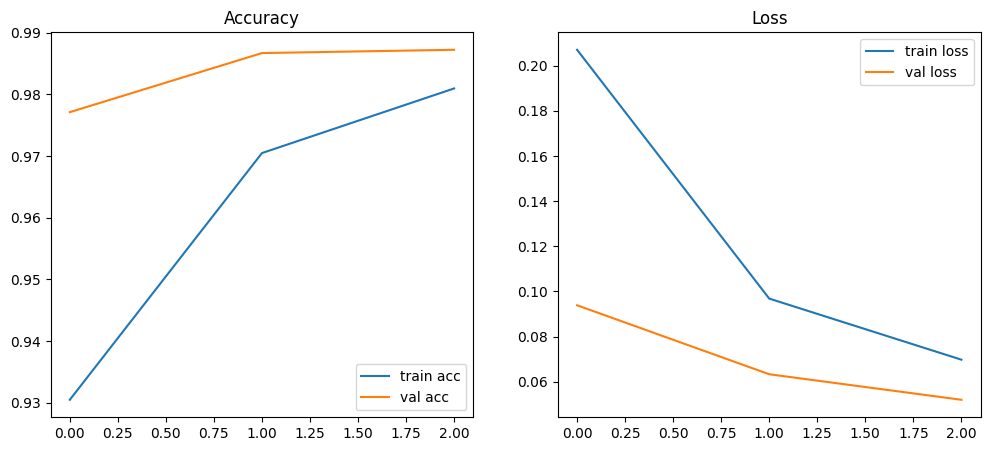

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss")
plt.legend()

plt.show()


### FINAL TEST METRICS

In [13]:
y_true, y_pred = [], []

for imgs, labels in test_ds:
    preds = final_model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).ravel())

print("\n=== FINAL TEST METRICS ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, pos_label=1))
print("Recall   :", recall_score(y_true, y_pred, pos_label=1))
print("F1-score :", f1_score(y_true, y_pred, pos_label=1))


=== FINAL TEST METRICS ===
Accuracy : 0.9872272485364556
Precision: 0.9944495837187789
Recall   : 0.9835315645013724
F1-score : 0.9889604415823368
